# BAYa class Assignment 2019

In this assignment, your task will be to implement and analyze inference in Bayesian Gaussian Mixture Model (GMM) as described in the slides on [Approximate Inference in Bayesian Models](http://www.fit.vutbr.cz/study/courses/BAYa/public/prednasky/4-Approximate%20inference.pdf). The preferred and easiest way of accomplishing this task is to complete this Jupyter Notebook, which already comes with training data definition and a code for Maximum Likelihood (ML) training of a contrastive GMM system. If you do not have any experience with Jupyter Notebook, the easiest way to start is to install Anaconda3, run Jupyter Notebook and open this notebook downloaded from [BAYa_Assignment2019.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/BAYa_Assignment2019.ipynb). You can also benefit from reusing pieces of code from the Jupyter Notebooks provided for this class, namely: [vb_gmm_training.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/vb_gmm_training.ipynb) and [gs_gmm_training.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/gs_gmm_training.ipynb).


The following cell contains a code with the definition of training data and the contrastive system training. You should not edit this part! The code does the following:

1. We "handcraft" a GMM (i.e. define GMM parameters) with 4 Gaussian components, which represents the "true distribution" of training data.
2. We have pre-generated training data from this GMM (see definition of variable x), so that everyone works with exactly the same data.
3. GMM with C=6 components is trained on the training data using ML training (the standard EM algorithm). You will use this GMM as a contrastive model. You will compare it to your implementation of VB GMM.
4. The following plots are made:
 * The true training data distribution (in grey).
 * The training observation generated from this true GMM (black + at the x axis).
 * The ML GMM estimate obtained using the EM algorithm (in black)
 $$
\DeclareMathOperator{\aalpha}{\boldsymbol{\alpha}}
\DeclareMathOperator{\bbeta}{\boldsymbol{\beta}}
\DeclareMathOperator{\NN}{\mathbf{N}}
\DeclareMathOperator{\ppi}{\boldsymbol{\pi}}
\DeclareMathOperator{\mmu}{\boldsymbol{\mu}}
\DeclareMathOperator{\llambda}{\boldsymbol{\lambda}}
\DeclareMathOperator{\diff}{\mathop{}\mathrm{d}}
\DeclareMathOperator{\zz}{\mathbf{z}}
\DeclareMathOperator{\XX}{\mathbf{X}}
\DeclareMathOperator{\xx}{\mathbf{x}}
\DeclareMathOperator{\YY}{\mathbf{Y}}
\DeclareMathOperator{\NormalGamma}{\mathcal{NG}}
$$

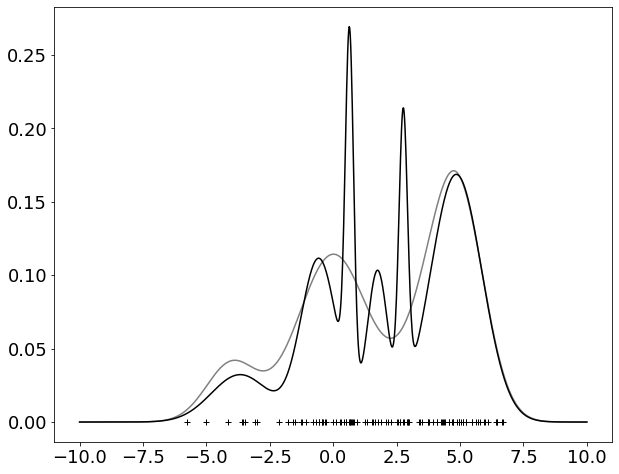

In [45]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.special import digamma
from scipy.special import gamma 
from scipy.special import loggamma
%matplotlib inline 
#%matplotlib qt5 #get an extra window for the plots
plt.rcParams.update({'figure.figsize': (10.0, 8.0), 'font.size': 18}) #Make the plots bigger


def GMM_pdf(x, mus, vars, pis):
  # Function for evaluating univariate GMM at values given by vector 'x'
  # 'mus', 'vars', 'pis' are vectors of means, variances and weights of individual Gaussian components
  # 'x[:,np.newaxis]' makes 'x' column vector to evaluate every coefficient of 'x' w.r.t. every Gaussian
  # component (row vectors 'mus' and 'vars') at once
  return sps.norm.pdf(x[:,np.newaxis], mus, np.sqrt(vars)).dot(pis) 


#1. Handcraft some GMM parameter 
mus_true = [-4.0, 0.0, 4.0, 5]
vars_true = [1.0, 1.96, 1.44, 1]
pis_true = [0.1, 0.4, 0.2, 0.3]

#2. Pregenerated N datapoints from the GMM distribution above 
x=np.array([ -3.07371088e+00, -4.14348725e+00, -3.01490821e+00, -3.54303388e+00, -3.48708234e+00, -3.59262207e+00,
 -5.76100178e+00, -5.02726789e+00, 8.28817153e-04, 4.99898450e-01, 2.83745605e-01, 6.71947042e-01,
 7.66679495e-01, 6.96995763e-01, 1.33546855e+00, 6.03847649e-01, -1.05992122e+00, 2.91024229e+00,
 -2.12682520e+00, 8.33533885e-01, 1.77147857e+00, 7.37629536e-01, -1.25040836e+00, 1.87318623e+00,
 -4.14582880e-01, 5.05680493e-01, 1.63091140e+00, 6.63219549e-01, -3.30841863e-01, -1.21874646e+00,
 2.64384057e+00, -4.32674840e-01, -1.79034947e+00, 3.13567565e-01, -5.43911715e-01, 2.28572951e+00,
 9.55653291e-01, -5.43582974e-01, -2.73850574e-01, -1.50383720e+00, 1.15925073e-01, 3.92541838e+00,
 -1.57267817e+00, 4.43581114e-01, -8.11856886e-01, 2.62442641e+00, -4.36298436e-01, -6.72286580e-01,
 1.52223784e+00, 1.25033658e+00, 4.88645989e+00, 2.96110183e+00, 4.74249957e+00, 2.17531545e+00,
 3.43072143e+00, 3.49315547e+00, 2.51223591e+00, 2.55369053e+00, 2.93122261e+00, 6.40247818e+00,
 5.12748233e+00, 4.08277439e+00, 4.96716209e+00, 1.56304959e+00, 4.31869585e+00, 2.07957592e+00,
 4.56265393e+00, 3.74342366e+00, 4.36177483e+00, 5.21824922e+00, 4.94100019e+00, 4.70062989e+00,
 6.12111884e+00, 6.69125720e+00, 5.03104495e+00, 5.72199065e+00, 4.29367941e+00, 3.72747772e+00,
 4.41461701e+00, 5.48741263e+00, 4.56782193e+00, 6.45701533e+00, 5.49118936e+00, 4.25947605e+00,
 3.39235348e+00, 4.10586407e+00, 2.76696554e+00, 6.66059909e+00, 6.00107916e+00, 5.92828295e+00,
 4.97460855e+00, 2.77746143e+00, 2.99416076e+00, 5.24459233e+00, 6.44720235e+00, 4.71084807e+00,
 5.62475093e+00, 3.76422931e+00, 5.79482964e+00, 5.11432194e+00])



#3. Choose some initial GMM parameters for EM training
C = 6                             # number of GMM components 
mus_ml = x[:C]                    # We choose few first observations as the initial means
vars_ml = np.repeat(np.var(x), C) # Variances for all components are set to the global variance of the training data
pis_ml = np.ones(C)/C             # All component weights are set to the same value 1/C

#EM algorithm for ML GMM training
for _ in range(1000):
  #E-step
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus_ml, np.sqrt(vars_ml)) + np.log(pis_ml)
  log_p_x  = logsumexp(log_p_xz, axis=1, keepdims=True)
  gammas_ml = np.exp(log_p_xz - log_p_x)
    
  #M-step
  Nc = gammas_ml.sum(axis=0)
  mus_ml  =  x.dot(gammas_ml) / Nc
  vars_ml =  (x**2).dot(gammas_ml) / Nc - mus_ml**2
  pis_ml  = Nc / Nc.sum()

#4. Plot the true GMM, ML trained GMM and the observations
t = np.linspace(-10,10,1000)
true_GMM_pdf = GMM_pdf(t, mus_true, vars_true, pis_true)
ml_GMM_pdf  = GMM_pdf(t, mus_ml, vars_ml, pis_ml);
plt.plot(t, true_GMM_pdf, 'gray')
plt.plot(t, ml_GMM_pdf, 'k')
plt.plot(x, np.zeros_like(x), '+k');

For for the Bayesian GMM, use the following setting of the prior parameters!

In [46]:
# Parameters of NormalGamma prior over means (mu) and precision (lambda)
m0, kappa0, a0, b0=[0.0, 0.05, 0.05, 0.05] 

#Parameters of Dirichlet prior weights
alpha0=1.0

## Variational Bayes inference

Now, include code the Variational Bayes (VB) approximate inference in Bayesian GMM.

* Use the responsibilities obtained from the ML training (EM algorithm implemented above; variable 'gammas_ml') to initialize $q(\zz)$. This implies that we use the same number of Gaussian components $C=6$ as for the ML training.

* Run iteratively the updates of $q(\mmu,\llambda)$, $q(\ppi)$ and $q(\zz)$ until the algorithm converges.

Once the VB inference converges:

* Plot the estimated approximate distributions $q(\mu_c,\lambda_c)$ for all the Gaussian components $c \in \{1\dts C\}$. You can reuse the code for plotting NormalGamma distribution from [vb_gmm_training.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/vb_gmm_training.ipynb) notebook.

* Print also the vector of parameters $\aalpha^*$ of the approximate posterior distribution of the weights $q(\ppi)$.

* Analyze these results. What can you say about the obtained posteriors distributions? What do they represent? How do these posterior distribution compare to the parameter estimates obtained from the EM algorithm?

* Generate several (say 50) samples from the approximate posterior distribution $q(\ppi,\mmu,\llambda) = q(\ppi) \prod_{c=1}^C q(\mu_c,\lambda_c)$. Each such sample is set of parameters of one GMM. Plot the GMM distributions corresponding to all the samples into a single figure. Comment on this plot. What do the individual GMM distributions represent?

* Now, average all the GMM distributions from the previous step. Attention! Average the GMM distributions, not their parameters as sampled from $q(\ppi,\mmu,\llambda)$. What can you say about the obtained average distribution? What does it represent?


* Run iteratively the updates of $q(\mmu,\llambda)$, $q(\ppi)$ and $q(\zz)$ until the algorithm converges.

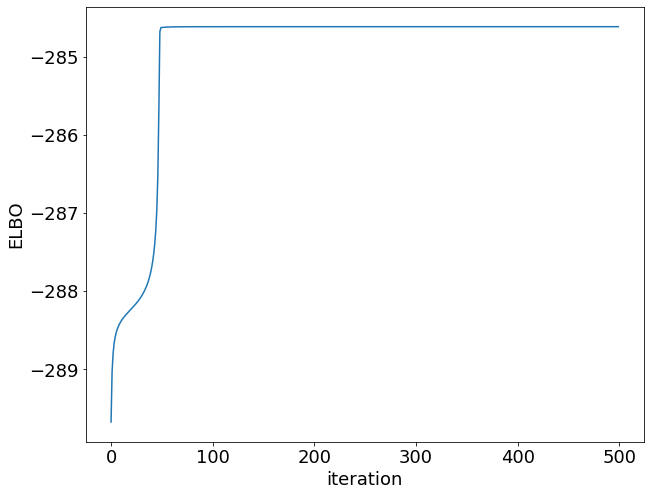

In [47]:
#initialize q(z)
q = gammas_ml
ELBO = list()

def NormalGamma(mu, lmbd, m, kappa, a, b):
    # sps.norm.pdf takes mean and std (not precision), therefore 1.0/np.sqrt()
    # sps.gamma.pdf takes shape and scale (not rate), therefore 1.0/b
    return sps.norm.pdf(mu, m, 1.0/np.sqrt(lmbd*kappa))* sps.gamma.pdf(lmbd, a, scale=1.0/b)

def NormalGamma_plot(m0, kappa0, a0, b0, limits):
   mu_vals, lmbd_vals = np.meshgrid(np.linspace(limits[0], limits[1], 500), np.linspace(limits[2], limits[3], 500))
   pdf = NormalGamma(mu_vals, lmbd_vals, m0, kappa0, a0, b0)
   plt.imshow(pdf, origin='lower', cmap='Greys', extent=limits)
   plt.xlabel('$\mu$'); plt.ylabel('$\lambda$')

def plot_VB_GMM(t, mN, kappaN, aN, bN, alphaN):
  # VB approximate posterior predictive for GMM (i.e. mixture of student's-t)
  pis = alphaN/alphaN.sum()
  p_xz = sps.t.pdf(t[:,np.newaxis], loc=mN, df=2*aN, scale=np.sqrt(bN*(kappaN+1)/aN/kappaN)) * pis 
  px = np.sum(p_xz, axis=1)
  plt.plot(t, p_xz, ':')
  plt.plot(t, px, 'k', label='VB posterior predictive')
  return px

def NormalGamma_rvs(m, kappa, a, b, N):
    # Sample from NormalGamma distribution
    lmbd = sps.gamma.rvs(a, scale=1.0/b, size=N)
    mu = sps.norm.rvs(m, 1.0/np.sqrt(lmbd*kappa), N)
    return mu, lmbd

def NormalGamma_KL(m1, kappa1, a1, b1, m2, kappa2, a2, b2):
    # Calculates KL(p1||p2) for two NormalGamma distributions 
    return 0.5 * (a1/b1 * kappa2*(m2-m1)**2 + kappa2/kappa1 - np.log(kappa2/kappa1) - 1
                 ) + a2*np.log(b1/b2) - loggamma(a1) + loggamma(a2) + (a1-a2)*digamma(a1)-(b1-b2)*a1/b1

def Dirichlet_KL(alpha1, alpha2):
    # Calculates KL(p1||p2) for two Dirichlet distributions 
    return (loggamma(np.sum(alpha1)) - np.sum(loggamma(alpha1)) 
          - loggamma(np.sum(alpha2)) + np.sum(loggamma(alpha2))
          + np.sum((alpha1 - alpha2)*(digamma(alpha1)-digamma(np.sum(alpha1)))))


for _ in range(500):
    #statistics
    Nc = q.sum(axis=0)
    fc =  x.dot(q)
    sc =  (x**2).dot(q)

    #hyperparameters for the normal gamma distribution
    kn = kappa0 + Nc
    mn = (kappa0*m0 + fc) / kn
    an = a0 + 0.5 * Nc
    bn = b0 + 0.5 * (sc + kappa0 * m0**2 - kn * mn**2)
    
    #update for the weights
    alphan=alpha0+Nc
    
    #update for the assignments of frames to gaussians
    logRho= 0.5* (digamma(an)-np.log(bn) - 1/kn - an/bn*(x[:,np.newaxis]-mn)**2 - np.log(2*np.pi)
                 ) + digamma(alphan)-digamma(np.sum(alphan))         
    logsumRho = logsumexp(logRho, axis=1, keepdims=True)
    q=np.exp(logRho-logsumRho)
    #print(np.sum(NormalGamma_KL(mn, kn, an, bn, ms, kap, a, b)))
    #print(Dirichlet_KL(alphan, alpha))
    #print((alphan, alpha))
    ELBO.append(sum(logsumRho) - np.sum(NormalGamma_KL(mn, kn, an, bn, m0, kappa0, a0, b0)) - Dirichlet_KL(alphan, alpha0))
    

plt.figure(3)
plt.plot(ELBO)
plt.ylabel('ELBO')
plt.xlabel('iteration');




* Plot the estimated approximate distributions $q(\mu_c,\lambda_c)$ for all the Gaussian components
* Print also the vector of parameters $\aalpha^*$ of the approximate posterior distribution of the weights $q(\ppi)$.

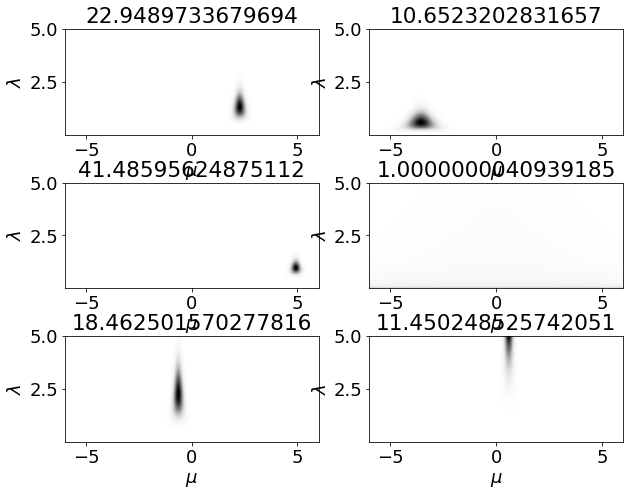

In [48]:
plt.figure(1)
for i in range(C):
   plt.subplot(3,2,i+1)
   plt.title(alphan[i])
   NormalGamma_plot(mn[i], kn[i], an[i], bn[i], limits=[-6, 6, 0.001, 5])

#alpha parameters are shown above each of GMM components, alpha tell us how certain it is about weights of each component

* Generate several (say 50) samples from the approximate posterior distribution $q(\ppi,\mmu,\llambda) = q(\ppi) \prod_{c=1}^C q(\mu_c,\lambda_c)$. Each such sample is set of parameters of one GMM. Plot the GMM distributions corresponding to all the samples into a single figure. Comment on this plot. What do the individual GMM distributions represent?

* Now, average all the GMM distributions from the previous step. Attention! Average the GMM distributions, not their parameters as sampled from $q(\ppi,\mmu,\llambda)$. What can you say about the obtained average distribution? What does it represent?



Text(0.5, 1.0, 'Samples from posterior')

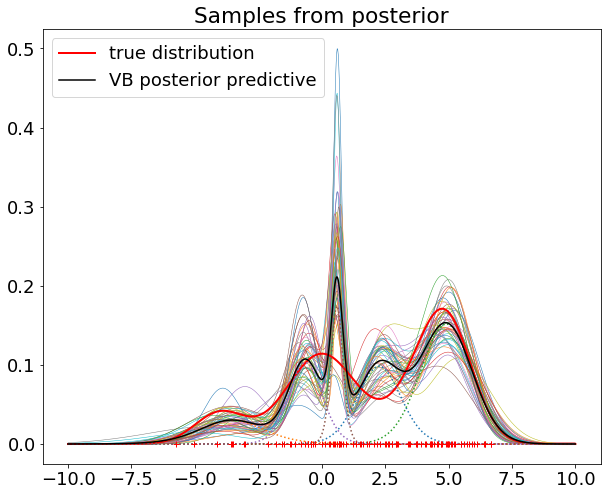

In [49]:
plt.figure(4)
for i in range(50):
  mus_sampled, lmbds_sampled = NormalGamma_rvs(mn, kn, an, bn, 6)
  pis_sampled = sps.dirichlet.rvs(alphan)
  #plot_GMM(t, mus_sampled, lmbds_sampled, pis_sampled)
  plt.plot(t, sps.norm.pdf(t[:,np.newaxis], mus_sampled, 1./np.sqrt(lmbds_sampled)).dot(pis_sampled.T), lw=0.5)
plt.plot(t, true_GMM_pdf, 'r', lw=2, label='true distribution')
vb_GMM_pdf=plot_VB_GMM(t, mn, kn, an, bn, alphan)
plt.plot(x, np.zeros_like(x), '+r')
plt.legend()
plt.title('Samples from posterior')

Comment on plot: 
1. Generate 6 samples from posterior distribution of GMM components (for each GMM component 1) + generate samples of weights. That give us one signle thin line in this plot, thus one GMM distribution.
2. The black line represent average of all of these thin lines, and thus represent the most probable GMM.

Now estimate and plot the VB (approximate) posterior predictive distribution.
How does the resulting posterior predictive distribution compare to:
- the true training data distribution
- the GMM obtained using ML training (i.e. using EM algorithm)
- the average of GMM distributions obtained in the previous step by sampling from $q(\ppi,\mmu,\llambda)$


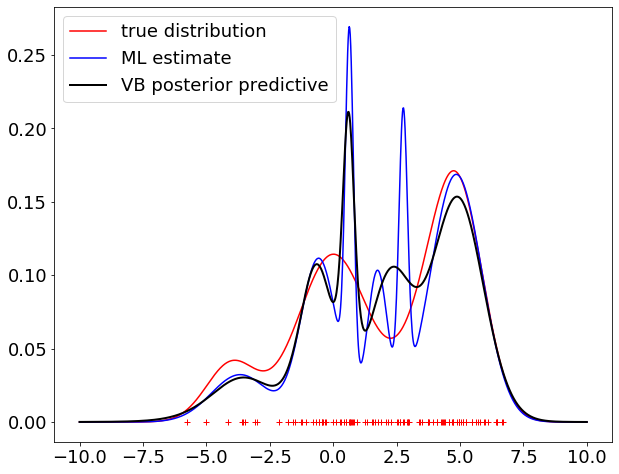

In [50]:

#plot update of mu and labmda parameters
#plt.figure()
#plt.clf()

plt.figure(2)
plt.plot(t, true_GMM_pdf, 'r', label='true distribution')
plt.plot(t, ml_GMM_pdf, 'b', label='ML estimate')
plt.plot(t, vb_GMM_pdf, 'k',lw=2, label='VB posterior predictive')

plt.plot(x, np.zeros_like(x), '+r');
plt.legend()






Commet on plot: is better than ml estimate, because ml tends to overfit with small datasets.

## Gibbs sampling inference
Now repeat the whole excercise, but this time using the inference based on Gibbs sampling (not the collapsed one). 

* Start from fixed $\zz$ initialized as the most likely assignments of observations to GMM components according the the ML training (i.e. assignment will be again derived from variable 'gammas_ml').

* In each iteration, plot the GMM distribution corresponding to the sample from $p(\ppi,\mmu,\llambda|\zz, \xx)$. What do the individual GMM distributions represent? How do they compare to the samples from the VB approximate posterior $q(\ppi,\mmu,\llambda)$?

* Average the distributions from the previous step to obtain an approximation to the posterior predictive distribution. Plot this distribution. How does it compare to the VB posterior predictive distribution? Is it any different? If yes, why?

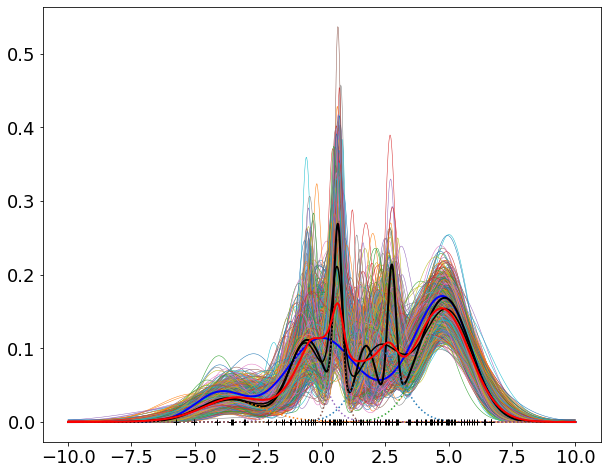

In [51]:
z = np.zeros((len(x), C))
z[np.arange(len(x)), np.argmax(gammas_ml, axis=1)] = 1


def NormalGamma_rvs(m, kappa, a, b, N):
    # Sample from NormalGamma distribution
    lmbd = sps.gamma.rvs(a, scale=1.0/b, size=N)
    mu = sps.norm.rvs(m, 1.0/np.sqrt(lmbd*kappa), N)
    return mu, lmbd

def GMMParamsPosteriorParams(alpha0, m0, kappa0, a0, b0, x, z):
    # Function estimates parameters of posterior distributions of GMM parameters given:
    #   - priors distributions (Dirichlet, NormalGamma)
    #   - observations 'x'
    #   - assignments of frames to gaussians 'z'
    # Input:
    #   alpha0 (C-dim. vector) - parameters of Dirichlet prior for GMM weights
    #   m0, kappa0, a0, b0 (4 scalars) - parameters of NormalGamma prior for Gaussian component params
    #   x (N-dim. vector) - vector of observations
    #   z (NxC matrix) - one-hot encodings assigning observations to Gaussian components
    # Output
    #   alphaN (C-dim. vector) - parameters of Dirichlet posterior for GMM weights
    #   mN, kappaN, aN, bN (4 C-dim. vectors) - parameters of NormalGamma posteriors for all GMM components
    #
    #   We use an alternative formulas for calculating the NormalGamma posteriors!!!
    #   (see function NormalGammaPosteriorParams2 from bayesian_inference_for_gaussian.ipynb)
    N = z.sum(axis=0)
    f =  x.dot(z)
    s =  (x**2).dot(z)
    alphaN = alpha0 + N
    kappaN = kappa0 + N
    mN = (kappa0*m0 + f) / kappaN;
    aN = a0 + 0.5*N;
    bN  = b0 + 0.5 * (s + kappa0 * m0**2 - kappaN * mN**2);
    return alphaN, mN, kappaN, aN, bN

#Iterations of Gibbs sampling
iters = 1000
expected_pdf = 0
for ii in range(iters):
  #Given z, calculate parameters of posterior distributions for all GMM parameters
  alphaN, mN, kappaN, aN, bN = GMMParamsPosteriorParams(alpha0, m0, kappa0, a0, b0, x, z)

  #Given z, sample GMM parameters from NormalGamma posteriors 
  mus, lmbds = NormalGamma_rvs(mN, kappaN, aN, bN, C)
  
  #Given z, sample GMM weights from Dirichlet posteriors
  pis = sps.dirichlet.rvs(alphaN)

  #Given GMM parameters, sample z
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus, np.sqrt(vars_ml)) + np.log(pis)
  gammas = np.exp(log_p_xz - logsumexp(log_p_xz, axis=1, keepdims=True))
  
  
  #used instead of sps version, cause of cause of some rounding error
  #z = np.vstack([sps.multinomial.rvs(1, gamma_n) for gamma_n in gammas])
  z = np.vstack([np.random.multinomial(1, gamma_n) for gamma_n in gammas])

  #We need to average PDFs of the "sampled GMMs" in order to evaluate the empiricl posterior predictive distribution
  pdf = sps.norm.pdf(t[:,np.newaxis], mus, 1./np.sqrt(lmbds)).dot(pis.T)
  expected_pdf +=  pdf
  plt.plot(t, pdf, lw=0.5)

#plot the true GMM, ML EM trained GMM and the empiricl posterior predictive distribution
plt.plot(t, true_GMM_pdf, 'b', lw=2);
plt.plot(t, ml_GMM_pdf, 'k', lw=2);
vb_GMM_pdf=plot_VB_GMM(t, mn, kn, an, bn, alphan)
plt.plot(t, expected_pdf/iters, 'r', lw=2);
plt.plot(x, np.zeros_like(x), '+k');

## More training data
Generate larger number of training observations (e.g. 1000 samples) from the true distribution (mus_true, vars_true, pis_true) and repeat the whole experiment once more (for both VB and Gibbs sampling inference) with the larger amount of training data. Regenerate all the plots and comment on how they change from the previous experiments with smaller training data set.

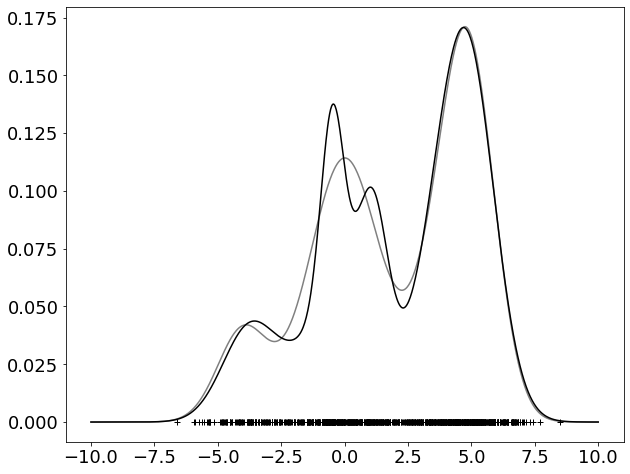

In [52]:
#generate 1000 samples 
N = 1000
Nc = sps.multinomial.rvs(N, pis_true) # Draw observation counts for each component from multinomial distribution
x = sps.norm.rvs(np.repeat(mus_true, Nc), np.repeat(np.sqrt(vars_true), Nc))
np.random.shuffle(x)

mus_ml = x[:C]                    # We choose few first observations as the initial means
vars_ml = np.repeat(np.var(x), C) # Variances for all components are set to the global variance of the training data
pis_ml = np.ones(C)/C             # All component weights are set to the same value 1/C


#EM algorithm for ML GMM training
for _ in range(1000):
  #E-step
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus_ml, np.sqrt(vars_ml)) + np.log(pis_ml)
  log_p_x  = logsumexp(log_p_xz, axis=1, keepdims=True)
  gammas_ml = np.exp(log_p_xz - log_p_x)
    
  #M-step
  Nc = gammas_ml.sum(axis=0)
  mus_ml  =  x.dot(gammas_ml) / Nc
  vars_ml =  (x**2).dot(gammas_ml) / Nc - mus_ml**2
  pis_ml  = Nc / Nc.sum()

#4. Plot the true GMM, ML trained GMM and the observations
t = np.linspace(-10,10,1000)
true_GMM_pdf = GMM_pdf(t, mus_true, vars_true, pis_true)
ml_GMM_pdf  = GMM_pdf(t, mus_ml, vars_ml, pis_ml);
plt.plot(t, true_GMM_pdf, 'gray')
plt.plot(t, ml_GMM_pdf, 'k')
plt.plot(x, np.zeros_like(x), '+k');

Try to implement as much as you can and answer as many questions as you can. It is fine if you do not understand some questions or if you do not know some of the answers.

Comment on plot after EM training:
As we can see from plot, EM training fits true GMM model very well as oppose to the first experiment with so few samples. This means our VB and GS will have better starting point. ML is less likely to overfit with increasing number of observed datapoints.

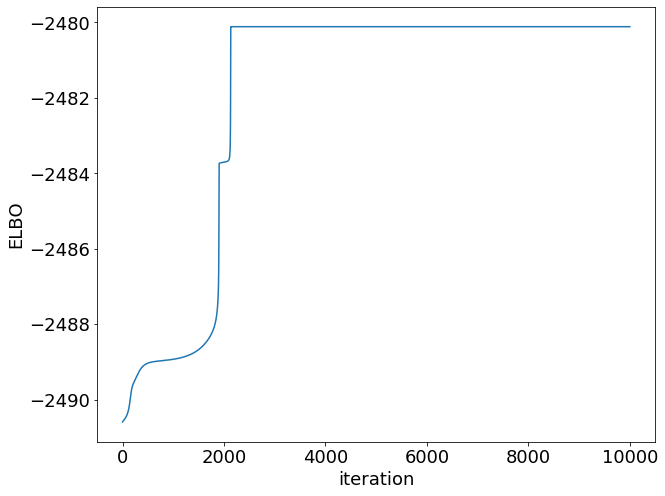

In [54]:
#run VB aproximate inference
#initialize q(z)
q = gammas_ml
ELBO = list()


for _ in range(10000):
    #statistics
    Nc = q.sum(axis=0)
    fc =  x.dot(q)
    sc =  (x**2).dot(q)

    #hyperparameters for the normal gamma distribution
    kn = kappa0 + Nc
    mn = (kappa0*m0 + fc) / kn
    an = a0 + 0.5 * Nc
    bn = b0 + 0.5 * (sc + kappa0 * m0**2 - kn * mn**2)
    
    #update for the weights
    alphan=alpha0+Nc
    
    #update for the assignments of frames to gaussians
    logRho= 0.5* (digamma(an)-np.log(bn) - 1/kn - an/bn*(x[:,np.newaxis]-mn)**2 - np.log(2*np.pi)
                 ) + digamma(alphan)-digamma(np.sum(alphan))         
    logsumRho = logsumexp(logRho, axis=1, keepdims=True)
    q=np.exp(logRho-logsumRho)
    #print(np.sum(NormalGamma_KL(mn, kn, an, bn, ms, kap, a, b)))
    #print(Dirichlet_KL(alphan, alpha))
    #print((alphan, alpha))
    ELBO.append(sum(logsumRho) - np.sum(NormalGamma_KL(mn, kn, an, bn, m0, kappa0, a0, b0)) - Dirichlet_KL(alphan, alpha0))
    

plt.figure(3)
plt.plot(ELBO)
plt.ylabel('ELBO')
plt.xlabel('iteration');    


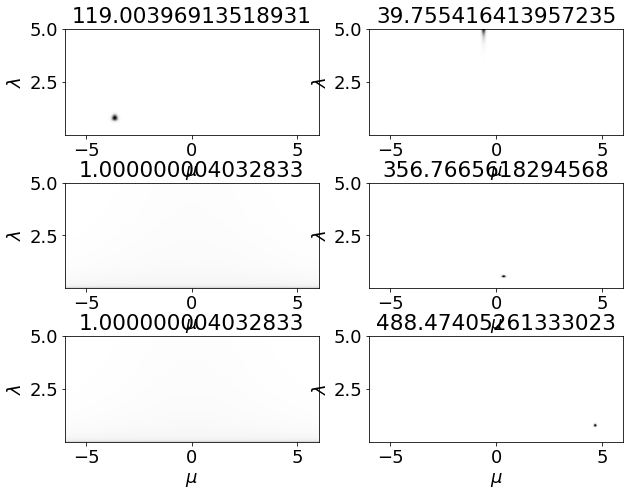

In [55]:
plt.figure(1)
for i in range(C):
   plt.subplot(3,2,i+1)
   plt.title(alphan[i])
   NormalGamma_plot(mn[i], kn[i], an[i], bn[i], limits=[-6, 6, 0.001, 5])

#alpha parameters are shown above each of GMM components, alpha tell us how certain it is about weights of each component

Text(0.5, 1.0, 'Samples from posterior')

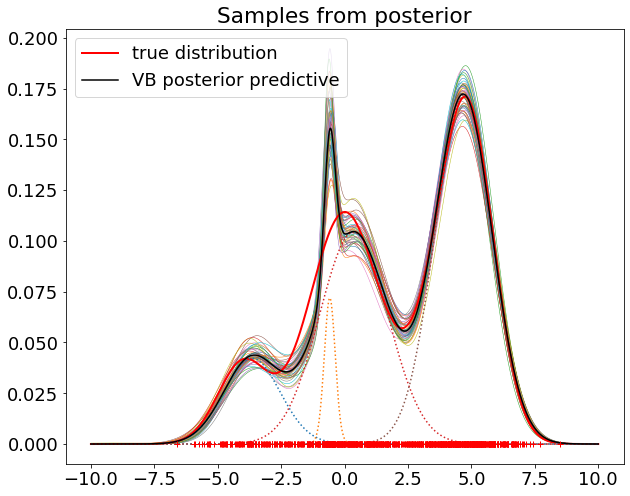

In [56]:
plt.figure(4)
for i in range(50):
  mus_sampled, lmbds_sampled = NormalGamma_rvs(mn, kn, an, bn, 6)
  pis_sampled = sps.dirichlet.rvs(alphan)
  #plot_GMM(t, mus_sampled, lmbds_sampled, pis_sampled)
  plt.plot(t, sps.norm.pdf(t[:,np.newaxis], mus_sampled, 1./np.sqrt(lmbds_sampled)).dot(pis_sampled.T), lw=0.5)
plt.plot(t, true_GMM_pdf, 'r', lw=2, label='true distribution')
vb_GMM_pdf=plot_VB_GMM(t, mn, kn, an, bn, alphan)
plt.plot(x, np.zeros_like(x), '+r')
plt.legend()
plt.title('Samples from posterior')

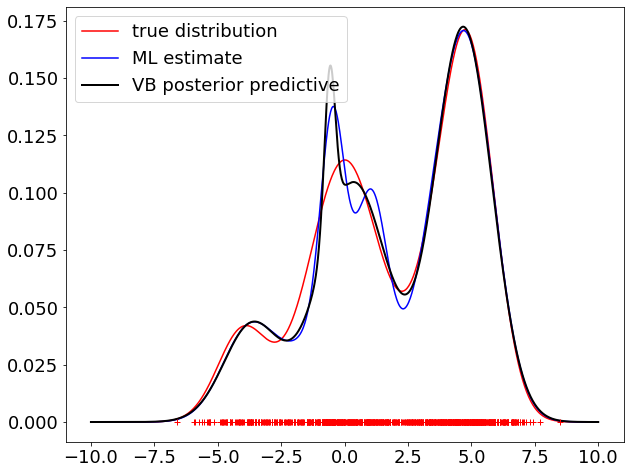

In [57]:
plt.figure(2)
plt.plot(t, true_GMM_pdf, 'r', label='true distribution')
plt.plot(t, ml_GMM_pdf, 'b', label='ML estimate')
plt.plot(t, vb_GMM_pdf, 'k',lw=2, label='VB posterior predictive')

plt.plot(x, np.zeros_like(x), '+r');
plt.legend()


Comment on VB aproximation:
We can see that, there is no big difference between ML and VB in case of enough sample data points. More datapoints also mean VB is quite confident and it takes more iteration before algorithm covergate.
But in this case it also seems ml fitsbetter.

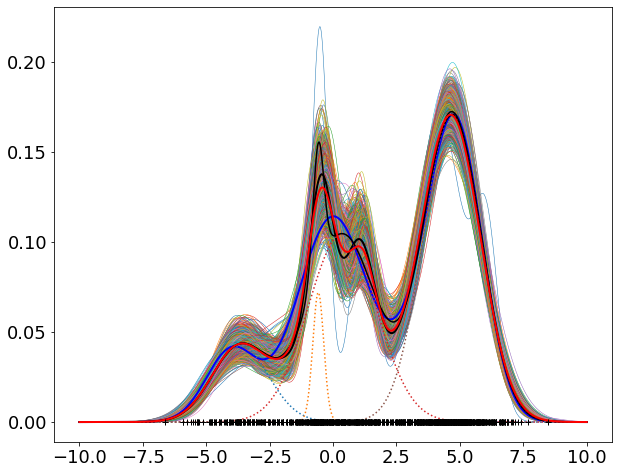

In [60]:
#RUN GS algorithm
z = np.zeros((len(x), C))
z[np.arange(len(x)), np.argmax(gammas_ml, axis=1)] = 1

#Iterations of Gibbs sampling
iters = 1000
expected_pdf = 0
for ii in range(iters):
  #Given z, calculate parameters of posterior distributions for all GMM parameters
  alphaN, mN, kappaN, aN, bN = GMMParamsPosteriorParams(alpha0, m0, kappa0, a0, b0, x, z)

  #Given z, sample GMM parameters from NormalGamma posteriors 
  mus, lmbds = NormalGamma_rvs(mN, kappaN, aN, bN, C)
  
  #Given z, sample GMM weights from Dirichlet posteriors
  pis = sps.dirichlet.rvs(alphaN)

  #Given GMM parameters, sample z
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus, np.sqrt(vars_ml)) + np.log(pis)
  gammas = np.exp(log_p_xz - logsumexp(log_p_xz, axis=1, keepdims=True))
  
  
  #used instead of sps version, cause of cause of some rounding error
  #z = np.vstack([sps.multinomial.rvs(1, gamma_n) for gamma_n in gammas])
  z = np.vstack([np.random.multinomial(1, gamma_n) for gamma_n in gammas])

  #We need to average PDFs of the "sampled GMMs" in order to evaluate the empiricl posterior predictive distribution
  pdf = sps.norm.pdf(t[:,np.newaxis], mus, 1./np.sqrt(lmbds)).dot(pis.T)
  expected_pdf +=  pdf
  plt.plot(t, pdf, lw=0.5)

#plot the true GMM, ML EM trained GMM and the empiricl posterior predictive distribution
plt.plot(t, true_GMM_pdf, 'b', lw=2);
plt.plot(t, ml_GMM_pdf, 'k', lw=2)
vb_GMM_pdf=plot_VB_GMM(t, mn, kn, an, bn, alphan)
plt.plot(t, expected_pdf/iters, 'r', lw=2);
plt.plot(x, np.zeros_like(x), '+k');

Comment on Gibb sampling:
As we can see from plot, GS fits model a little bit better than VB and ML.